In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# [머신러닝]

In [138]:
import pandas as pd
import numpy as np
import os
os.listdir("/kaggle/input")

# 데이터 불러오기
raw = pd.read_csv("/kaggle/input/adp-book-data/diabetes_for_test.csv")

In [139]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   759 non-null    float64
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  762 non-null    float64
 7   Age                       765 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [140]:
raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,NaN,33.0,1


In [141]:
raw.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,733.000000,768.000000,759.000000,767.000000,762.000000,765.000000,768.000000
mean,3.845052,120.894531,72.405184,20.536458,73.384717,31.946806,0.458731,33.207843,0.348958
std,3.369578,31.972618,12.382158,15.952218,98.934519,7.786526,0.296763,11.703467,0.476951
min,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.241500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,22.000000,32.000000,0.369000,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,125.000000,36.550000,0.613750,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,495.000000,59.400000,1.731000,81.000000,1.000000


In [142]:
from collections import Counter
print(Counter(data.Outcome))
# 레이블의 비율에 차이가 남 클래스 비율을 맞춰주는 것이 좋다.

Counter({0: 500, 1: 268})


In [143]:
x_col = list(raw.columns)
x_col.remove('Outcome')
x_col

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

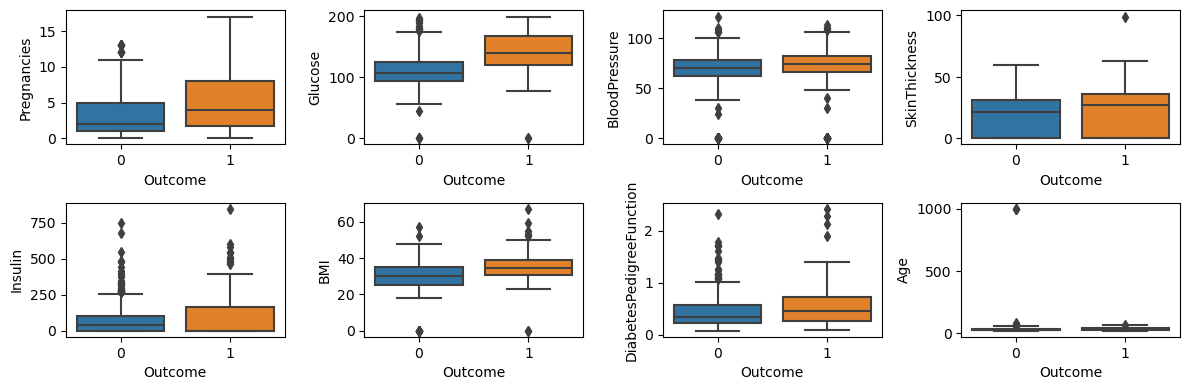

In [146]:
n_row = 2
n_col = 4
fig, axs = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*2))

# sns.boxplot(x = 'Outcome', y = 'Pregnancies', data = data, ax = axs[0][0])

for r in range(0, n_row):
    for c in range(0, n_col):
        i = r*n_col+c
        if i < len(x_col):
            sns.boxplot(x = 'Outcome', y = x_col[i], data = raw, ax = axs[r][c])
plt.tight_layout()
plt.show()

<AxesSubplot:>

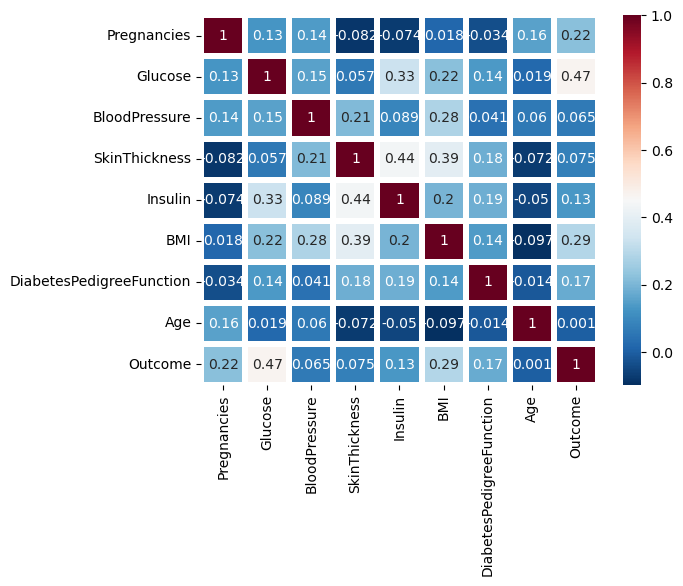

In [7]:
import seaborn as sns
data_cor = data.corr(method = 'pearson')
sns.heatmap(data_cor,
           xticklabels = data_cor.columns,
           yticklabels = data_cor.columns,
           cmap = 'RdBu_r',
           annot = True, 
           linewidth = 3)

### 이상치 제거

In [53]:
def out_iqr(df, col, v = 1.5):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1

    lower_whs = q1 - (iqr * v)
    upper_whs = q3 + (iqr * v)
    out = df[(df[col]>upper_whs) | (df[col] < lower_whs)]
    return out[[col]]

In [184]:
from sklearn.impute import KNNImputer
data = raw.copy()
imputer = KNNImputer()

# 컬럼별 이상치 식별 및 knn 대체
for col in x_col:
    out = out_iqr(data, col, 3)
#     print(data.loc[out.index, col])
    
    # 이상치를 NaN으로 변경
    data.loc[out.index, col] = np.NaN
    
#   단순 평균 대치
#     data[col] = data[col].fillna(data[col].mean())

#     # 바뀐 데이터 확인
#     print(data.loc[out.index, col])

# 결측 데이터 처리
data_fill = imputer.fit_transform(data)
data_fill = pd.DataFrame(data_fill, columns = data.columns)

# 결측치 확인
data_fill.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

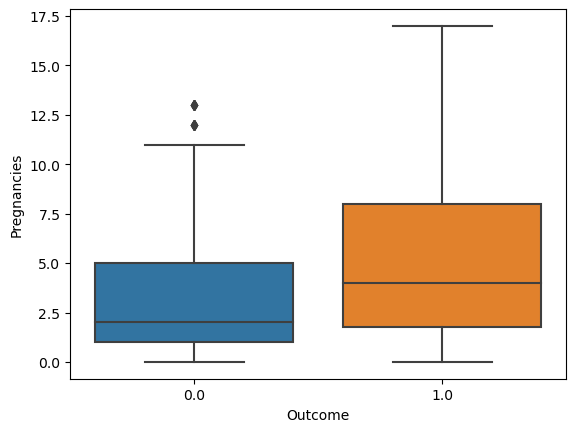

In [67]:
import seaborn as sns
for i in x_col[:1]:
    sns.boxplot(x = 'Outcome', y = i, data = data_fill)
    plt.show()


# 클래스 불균형 처리
## (1) 업샘플링

In [85]:
!pip install imbalanced-learn
# 단순 업샘플링
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
data_sam_x,data_sam_y  = oversample.fit_resample(X = data_fill[x_col], y = data_fill['Outcome'])
print(Counter(data_sam_y))

Counter({1.0: 500, 0.0: 500})


In [175]:
# SMOTE 방법

from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(sampling_strategy = 'minority')
x_data, y_data = smote_sample.fit_resample(X = data_fill[x_col], y = data_fill['Outcome'])
print(Counter(y_data))

Counter({1.0: 500, 0.0: 500})


## (2) 언더샘플링

In [147]:
# 단순 언더 샘플링
from imblearn.under_sampling import RandomUnderSampler

print(Counter(data_fill.Outcome))

undersample = RandomUnderSampler()
data_sam_x,data_sam_y  = undersample.fit_resample(X = data_fill[x_col], y = data_fill['Outcome'])
print(Counter(data_sam_y))

Counter({0.0: 500, 1.0: 268})
Counter({0.0: 268, 1.0: 268})


# 3. 모델링
## (1) 최소 3개 이상 알고리즘

In [176]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler
x_data_scale = StandardScaler().fit_transform(x_data)

x_data_scale

y_data_r = y_data.values.ravel()

# 데이터 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data_scale, y_data_r, test_size = 0.2, random_state = 2022)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8)
(200, 8)
(800,)
(200,)


In [177]:
import time

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [178]:
rf = RandomForestClassifier(n_estimators = 100)
dt = DecisionTreeClassifier()
xgb = XGBClassifier(n_estimators = 100)
lgb = LGBMClassifier(n_estimators = 100)

In [179]:
def model_result(model, grid):
    start = time.time()
    
    # 모델 생성
    m = GridSearchCV(model, param_grid = grid, cv = 5)
    m.fit(x_train, y_train)
    
    # 시간 측정
    m_time = time.time() - start
    
    # 예측
    y_pred = m.predict(x_test)
    
    # 평가
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print('auc 값 : ',  auc(fpr, tpr))
    print('정확도 : ',  accuracy_score(y_pred, y_test))
    print('학습시간: ',  m_time)

In [180]:
rf_grid = [
    {'max_depth' : [2,4,6,8],
     'min_samples_split' : [2, 4, 6, 8]
    }
]
dt_grid = [
    {'max_depth' : [2,4,6,8],
     'min_samples_split' : [2, 4, 6, 8]
    }
]
xgb_grid = [
    {'max_depth' : [2,4,6,8]
    }
]
lgb_grid = [
    {'max_depth' : [2,4,6,8]
    }
]

In [181]:
print("rf")
model_result(rf, rf_grid)
print("dt")
model_result(dt, dt_grid)
print("xgb")
model_result(xgb, xgb_grid)
print("lgb")
model_result(lgb, lgb_grid)

auc 값 :  0.8299829982998299
정확도 :  0.83
학습시간:  15.878631353378296
auc 값 :  0.7603760376037604
정확도 :  0.76
학습시간:  0.2695736885070801
auc 값 :  0.8652365236523651
정확도 :  0.865
학습시간:  8.529906272888184
auc 값 :  0.8051305130513051
정확도 :  0.805
학습시간:  3.87414288520813


## (3) 차원 축소 후 예측 성능과 속도 비교

In [166]:
from sklearn.decomposition import PCA
pca = PCA(n_components =5) # 주성분 개수

pca_fit = pca.fit(x_data_scale)

print('고유값 : ', pca.singular_values_)
print('분산설명력 : ', pca.explained_variance_ratio_)

고유값 :  [45.3352844  42.68924898 30.98519013 30.26747327 28.87428155]
분산설명력 :  [0.256911   0.2277965  0.12001025 0.11451499 0.10421552]


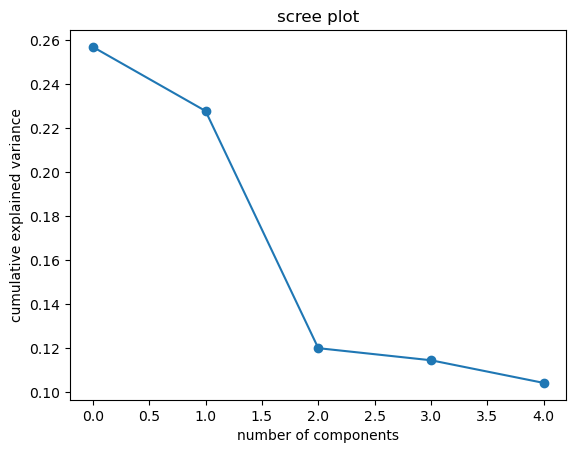

In [167]:
import matplotlib.pyplot as plt

plt.title('scree plot')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.show()

In [182]:
pca = PCA(n_components =3) # 주성분 개수

x_data_pca = pca.fit_transform(x_data_scale)

# 데이터 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data_pca, y_data_r, test_size = 0.2, random_state = 2022)

In [183]:
print("rf")
model_result(rf, rf_grid)
print("dt")
model_result(dt, dt_grid)
print("xgb")
model_result(xgb, xgb_grid)
print("lgb")
model_result(lgb, lgb_grid)

rf
auc 값 :  0.7094709470947096
정확도 :  0.71
학습시간:  16.102184534072876
dt
auc 값 :  0.7042204220422044
정확도 :  0.705
학습시간:  0.20697236061096191
xgb
auc 값 :  0.7147214721472147
정확도 :  0.715
학습시간:  7.975466012954712
lgb
auc 값 :  0.6946194619461946
정확도 :  0.695
학습시간:  3.624265670776367


# [통계분석]

## 1. 금속함유량 검정

In [249]:
import pandas as pd
import numpy as np
import os
os.listdir("/kaggle/input")

# 데이터 불러오기
raw = pd.read_csv("/kaggle/input/adp-book-data/metalicity")
raw.head()

,metalicity
0,42.731551
1,46.429668
2,45.754023
3,45.808060
4,44.072529


In [256]:
# 정규성검정
from scipy.stats import shapiro
shapiro(raw)

# pvalue가 0.05보다 크므로 H0을 채택하여 정규분포를 따른다.

ShapiroResult(statistic=0.9822468757629395, pvalue=0.05002119019627571)

In [259]:
# 원데이터의 평균을 가지고 분산이 1.3인 샘플데이터를 150개 만듬

test = np.random.normal(np.mean(raw.metalicity), 1.3, len(raw.metalicity))
from scipy import stats

stats.bartlett(raw.metalicity, test)
# pvalue가 0.05보다 작으므로 귀무가설을 기각하지 못한다. 따라서, 금속 재질 함유량의 분산은 1.3이 아니다 

BartlettResult(statistic=17.057013625852296, pvalue=3.62741529085557e-05)

## 2. p관리도를 구하고 시각화 하시오.

In [261]:
df2 = pd.read_csv("/kaggle/input/adp-book-data/lot_quality.csv")
df2.head()

,lot,생산수량,불량수량
0,1,587,19
1,2,588,15
2,3,455,19
3,4,666,12
4,5,750,15


In [264]:
df2.불량수량*100 / df2.생산수량

0      3.236797
1      2.551020
2      4.175824
3      1.801802
4      2.000000
         ...   
195    2.852615
196    3.716814
197    2.105263
198    1.934236
199    2.133333
Length: 200, dtype: float64

In [267]:
df2['p'] = df2.불량수량 / df2.생산수량
cl = sum(df2.불량수량)/ sum(df2.생산수량)
cl

0.029024320840935338

In [272]:
df2['ucl'] = df2['p']+3*np.sqrt((df2['p']*(1-df2['p']))/len(df2['p']))
df2['lcl'] = df2['p']-3*np.sqrt((df2['p']*(1-df2['p']))/len(df2['p']))
df2

,lot,생산수량,불량수량,p,관리상한선,관리하한선,ucl,lcl
0,1,587,19,0.032368,0.069910,-0.005174,0.069910,-0.005174
1,2,588,15,0.025510,0.058957,-0.007936,0.058957,-0.007936
2,3,455,19,0.041758,0.084192,-0.000676,0.084192,-0.000676
3,4,666,12,0.018018,0.046235,-0.010199,0.046235,-0.010199
4,5,750,15,0.020000,0.049698,-0.009698,0.049698,-0.009698
...,...,...,...,...,...,...,...,...
195,196,631,18,0.028526,0.063840,-0.006788,0.063840,-0.006788
196,197,565,21,0.037168,0.077298,-0.002962,0.077298,-0.002962
197,198,570,12,0.021053,0.051506,-0.009401,0.051506,-0.009401
198,199,517,10,0.019342,0.048558,-0.009874,0.048558,-0.009874


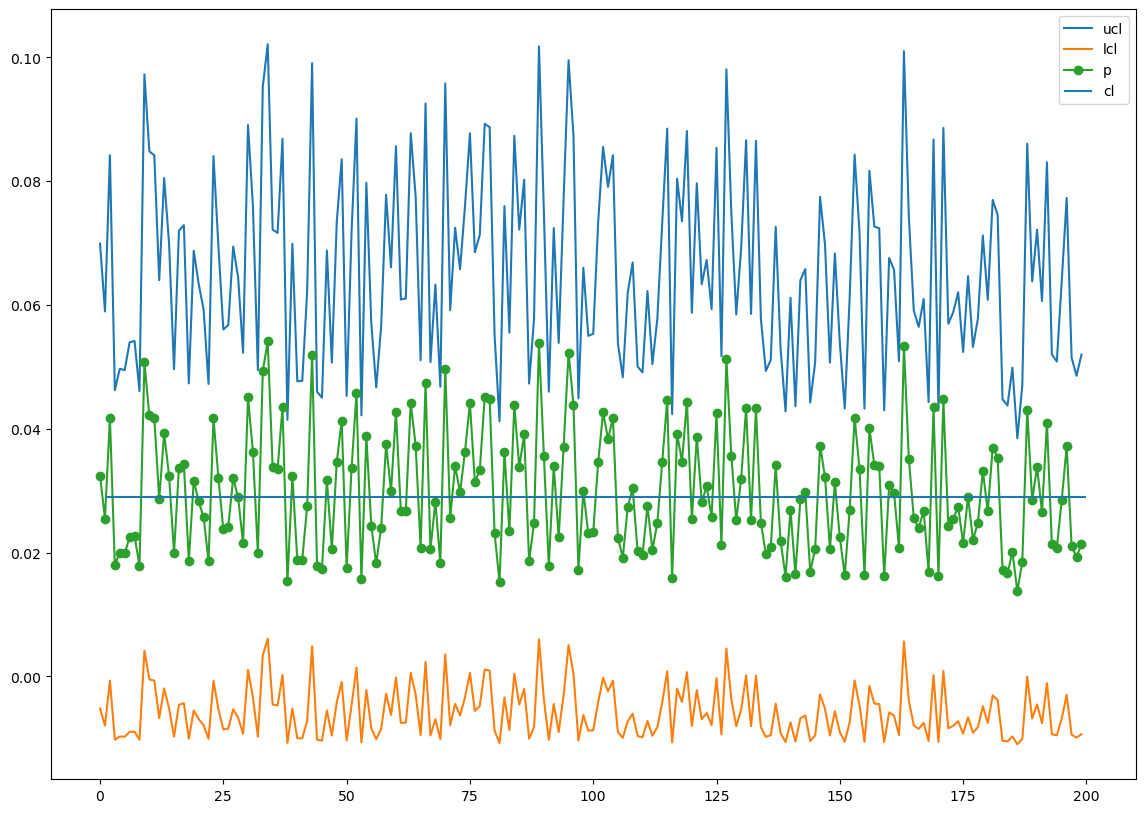

In [274]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 10))
plt.plot(df2['ucl'])
plt.plot(df2['lcl'])
plt.plot(df2['p'], marker = 'o')
plt.hlines(cl, 1, 200)
plt.legend(['ucl', 'lcl', 'p', 'cl'])


In [217]:
# p2가 최대로 만들어질 경우
p1 = 0
p2 = 32

# 잔여 재료
a = 1300 - 40*p2 - 20*p1
b = 1000 - 30*p2 - 20*p1
c = 1200 - 30*p2 - 20*p1

print(a)
print(b)
print(c)

20
40
240


In [219]:
# p1이 최대로 만들어질 경우
p1 = 50
p2 = 0

# 잔여 재료
a = 1300 - 40*p2 - 20*p1
b = 1000 - 30*p2 - 20*p1
c = 1200 - 30*p2 - 20*p1

print(a)
print(b)
print(c)

300
0
200


In [248]:
lst_p2 = []
lst_p1 = []
lst_money = []

for i in range(32):
    # p1이 최대로 만들어질 경우
    p2 = 32-i
    
    # p2 만들고 난 잔여 재료
    a = 1300 - 40*p2
    b = 1000 - 30*p2
    c = 1200 - 30*p2
    
    p1 = min(int(a/20), int(b/20), int(c/20))
    money = p1*12 + p2*18
    lst_p1.append(p1)
    lst_p2.append(p2)
    lst_money.append(money)

pd.DataFrame({'p1':lst_p1, 'p2':lst_p2, 'money':lst_money}).head()

,p1,p2,money
0,1,32,588
1,3,31,594
2,5,30,600
3,6,29,594
4,8,28,600


# 구매패턴의 연관성 검정
- h0 : 연속적인 관측값이 임의적이다. 즉, 연관성이 없다.
- h0 : 연속적인 관측값이 임의적이 아니다. 즉, 연관성이 있다.

In [ ]:
# 

In [281]:
t = ['a a b b a a a a b b b b b a a b b a b b']
t = t[0].split(' ')
df = pd.DataFrame({'p' : t})
df['p1'] = df['p'].map({'a':0, 'b':1})
df.head()

,p,p1
0,a,0
1,a,0
2,b,1
3,b,1
4,a,0


In [289]:
# !pip install statsmodels
# 무작위성 검정
from statsmodels.sandbox.stats.runs import runstest_1samp

runstest_1samp(df['p1'])

(-1.1144881152070183, 0.26506984027306035)